## Introduce a Validation Set to the Training Loop 

In [177]:
#import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

#### Download and Prepare CIFAR10 Dataset

In [178]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #change for true values
])

dataset = torchvision.datasets.CIFAR10(root = './data/CIFAR10'
                                       , train = True
                                       , download = True
                                       , transform = transform)

trainset, validset = torch.utils.data.random_split(dataset, [40000, 10000])

trainloader = DataLoader(trainset
                        , batch_size = 32
                        , shuffle = True
                        , num_workers = 1)

validloader = DataLoader(validset
                        , batch_size = 32
                        , shuffle = True
                        , num_workers = 1)



testset = torchvision.datasets.CIFAR10(root = './data/CIFAR10'
                                      , train = False
                                      , download = True
                                      , transform = transform)
testloader = DataLoader(testset
                       , batch_size = 32
                       , shuffle = False
                       , num_workers = 1)

Files already downloaded and verified
Files already downloaded and verified


In [179]:
#CIFAR10 classes
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [180]:
len(dataset)

50000

In [181]:
len(trainset), len(validset)

(40000, 10000)

In [182]:
#Load one image
sample = next(iter(trainset))
img, lbl = sample
img.shape

torch.Size([3, 32, 32])

#### Defining our CNN

In [183]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.conv3 = nn.Conv2d(12, 24, 3)
        
        self.fc1 = nn.Linear(24*4*4, 200)
        self.fc2 = nn.Linear(200, 120)
        self.fc3 = nn.Linear(120, 60)
        self.out = nn.Linear(60, 10)
    
    def forward(self, t):
        #print('conv1')
        t = self.conv1(t)
        t = F.relu(t)
        #print(t.shape)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        #print(t.shape)
        
        #print('conv2')
        t = self.conv2(t)
        t = F.relu(t)
        #print(t.shape)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        #print(t.shape)
        
        #print('conv3')
        t = self.conv3(t)
        t = F.relu(t)
        #print(t.shape)
        #t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        #print(t.shape)
        
        
        t = t.reshape(-1,24*4*4)
        #print('fc1 reshape:', t.shape)
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.fc3(t)
        t = F.relu(t)
        
        t = self.out(t)
        #softmax?
        
        return t

In [184]:
#Initiating new CNN
cnn1 = CNN()

In [185]:
#Testing wheter img moves through, controlling convolutions through print statements
pred = cnn1(img.unsqueeze(0))

#### Optimizer and Loss

In [198]:
cnn = CNN()

In [199]:
optimizer = optim.SGD(cnn.parameters(), lr = 0.01)

criterion = nn.CrossEntropyLoss()

#### Defining Training and Validation Functions

In [200]:
def validate(model, val_dataloader):
    model.eval()
    val_running_loss = 0
    val_running_corr = 0
    for batch in val_dataloader:
        images, labels = batch
        preds = model(images)
        loss = criterion(preds, labels)
        
        val_running_loss += loss.item()
        _, predsmax = torch.max(preds.data, 1)
        val_running_corr += (predsmax == labels).sum().item()
        
    val_loss = val_running_loss / len(val_dataloader.dataset)
    val_accuracy = 100 * val_running_corr / len(val_dataloader.dataset)
    
    print(f'Valid Loss: {val_loss:.4f}, Valid Acc %: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

In [201]:
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0
    train_running_corr = 0
    for batch in train_dataloader:
        images, labels = batch
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        
        train_running_loss += loss.item()
        _, predsmax = torch.max(preds.data, 1)
        train_running_corr += (predsmax == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
        
    train_loss = train_running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * train_running_corr / len(train_dataloader.dataset)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc %: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

#### Trainings Loop

In [202]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(10):
    print('Epoch ', epoch)
    train_epoch_loss, train_epoch_acc = train(cnn, trainloader)
    val_epoch_loss, val_epoch_acc = validate(cnn, validloader)
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_acc)

Epoch  0
Train Loss: 0.0720, Train Acc %: 9.99
Valid Loss: 0.0721, Valid Acc %: 10.01
Epoch  1
Train Loss: 0.0720, Train Acc %: 10.12
Valid Loss: 0.0721, Valid Acc %: 13.49
Epoch  2
Train Loss: 0.0719, Train Acc %: 10.82
Valid Loss: 0.0720, Valid Acc %: 10.03
Epoch  3
Train Loss: 0.0719, Train Acc %: 13.16
Valid Loss: 0.0720, Valid Acc %: 11.25
Epoch  4
Train Loss: 0.0717, Train Acc %: 15.72
Valid Loss: 0.0712, Valid Acc %: 19.03
Epoch  5
Train Loss: 0.0667, Train Acc %: 19.82
Valid Loss: 0.0639, Valid Acc %: 22.41
Epoch  6
Train Loss: 0.0609, Train Acc %: 27.11
Valid Loss: 0.0588, Valid Acc %: 30.14
Epoch  7
Train Loss: 0.0570, Train Acc %: 32.21
Valid Loss: 0.0561, Valid Acc %: 34.26
Epoch  8
Train Loss: 0.0542, Train Acc %: 35.99
Valid Loss: 0.0527, Valid Acc %: 37.42
Epoch  9
Train Loss: 0.0518, Train Acc %: 39.05
Valid Loss: 0.0509, Valid Acc %: 40.51


#### Apply Test Set

In [203]:
def test(model, test_loader):
    test_correct = 0
    
    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            images, labels = batch
            preds = model(images)
        
            test_correct += preds.argmax(dim = 1).eq(labels).sum().item()
    
    test_accuracy = 100 * test_correct / len(test_loader.dataset)    
    print('Accuracy on TestSet in %:', test_accuracy)
    
    #return test_correct, test_accuracy

In [206]:
test(cnn, testloader)

Accuracy on TestSet in %: 40.33


#### Plot Train and Validation Set Performance of the Model

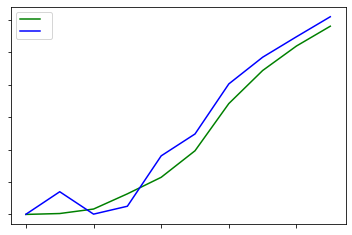

In [207]:
plt.plot(train_accuracy, color = 'green', label = 'Train Accuracy')
plt.plot(val_accuracy, color = 'blue', label = 'Validation Accuracy')
plt.legend()
plt.show()

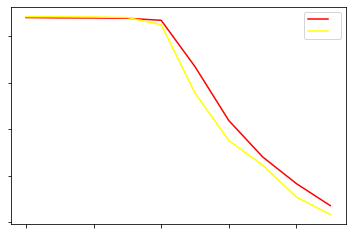

In [208]:
plt.plot(train_loss, color = 'red', label = 'Train Accuracy')
plt.plot(val_loss, color = 'yellow', label = 'Validation Accuracy')
plt.legend()
plt.show()

#### Save the network

In [213]:
#saving whole network
path = './models/cifar10_selfbuild.pth'
torch.save(cnn, path)

In [214]:
#save the params
path = './models/cifar10_selfbuild_params.pth'
torch.save(cnn.state_dict(), path)